In [1]:
import os
from glob import glob

cwd = os.getcwd()
data_path = glob(cwd+"/Data/data_road/training/image_2/um_*")
data_path = sorted(data_path)

In [2]:
import matplotlib.image as mpimg
import numpy as np

imgs = []
for path in data_path:
    img = mpimg.imread(path)
    shape = np.shape(img)
    img = img[int(shape[0]/2):,:,:]
    imgs.append(img)

/home/mikep/hdd/Documents/Probabalistic_model/Data/data_road/training/image_2/um_000002.png


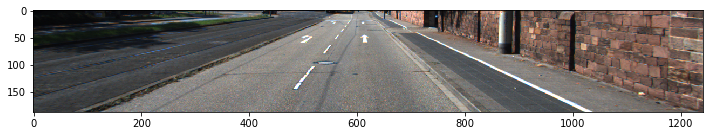

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

ind = 2
img = imgs[ind]
print(data_path[ind])

plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.show()

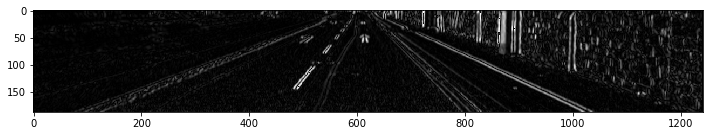

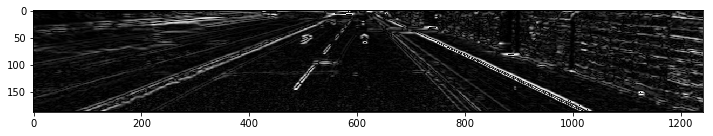

In [4]:
import cv2

grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
# Apply blurring
kernel_size = 3
blur = cv2.GaussianBlur(grey,(kernel_size, kernel_size),0)

sobelx = cv2.Sobel(blur,cv2.CV_64F,1,0,ksize=7)
abs_sobelx64f = np.absolute(sobelx)
sobelx_8u = np.uint8(abs_sobelx64f)

sobely = cv2.Sobel(blur,cv2.CV_64F,0,1,ksize=7)
abs_sobely64f = np.absolute(sobely)
sobely_8u = np.uint8(abs_sobely64f)

plt.figure(figsize=(12, 12))
plt.imshow(sobelx_8u, cmap="gray")
plt.show()

plt.figure(figsize=(12, 12))
plt.imshow(sobely_8u, cmap="gray")
plt.show()

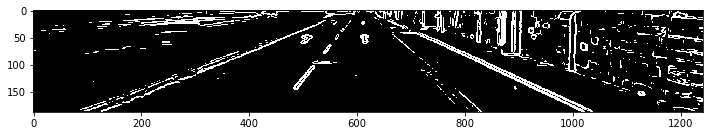

In [5]:
shape = np.shape(grey)

combined = np.zeros(shape)

thresh = 75

for i in range(shape[0]):
    for j in range(shape[1]):
        if sobelx_8u[i,j] > thresh or sobely_8u[i,j] > thresh:
            combined[i,j] = 255
            
plt.figure(figsize=(12, 12))
plt.imshow(combined, cmap="gray")
plt.show()

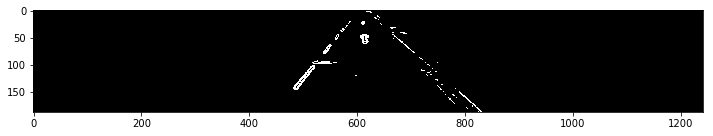

In [6]:
# Form the ROI mask
ignore_mask_color = 255
mask = np.zeros_like(combined)
imshape = combined.shape
#vertices = np.array([[(imshape[1]*.07,imshape[0]),(np.floor(imshape[1]/2.1), np.floor(imshape[0]/1.7)), (np.floor(imshape[1]/1.9), np.floor(imshape[0]/1.7)), (imshape[1]*.95,imshape[0])]], dtype=np.int32)
top_left = (np.floor(.5 * shape[1]), 0)
top_right = (np.floor(.5 * shape[1]), 0)
bot_left = (np.floor(.25 * shape[1]), shape[0])
bot_right = (np.floor(.75 * shape[1]), shape[0])

vertices = np.array([[bot_left, top_left, top_right, bot_right]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(combined, mask)

plt.figure(figsize=(12,12))
plt.imshow(masked_edges, cmap="gray")
plt.show()

In [7]:
n = 5
divide = int(shape[0]/n)

pieces = []
for i in range(n):
    h0 = i * divide
    h1 = h0 + divide
    piece = masked_edges[h0:h1,:]
    pieces.append(piece)

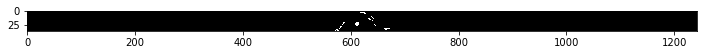

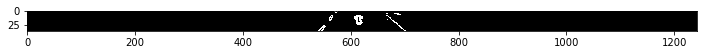

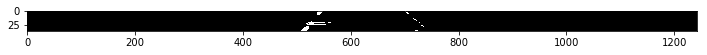

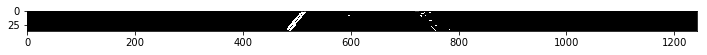

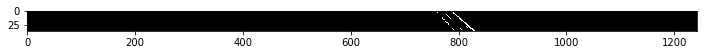

In [8]:
for piece in pieces:
    plt.figure(figsize=(12,12))
    plt.imshow(piece,cmap="gray")
    plt.show()

In [9]:
hists = []
for piece in pieces:
    hist = np.sum(piece[int(piece.shape[0]/2):], axis=0)
    hists.append(hist)

In [10]:
left_hists = []
right_hists = []
midpoint = int(hists[0].size/2)
for hist in hists:
    left_hist = hist[0:midpoint]
    right_hist = hist[midpoint:]
    left_hists.append(left_hist)
    right_hists.append(right_hist)

In [11]:
np.shape(pieces[0])

(37, 1242)

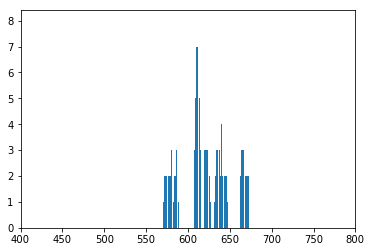

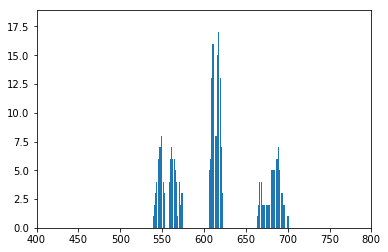

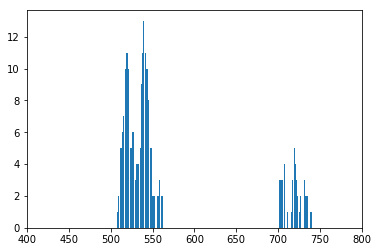

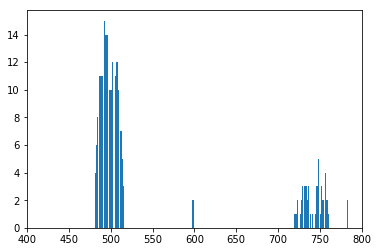

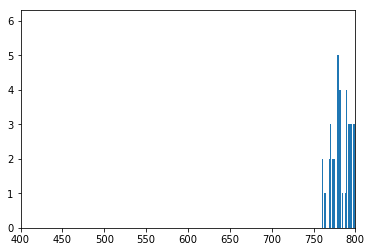

In [12]:
for piece in pieces:
    hist = np.zeros(np.shape(piece)[1])
    x = np.arange(np.shape(piece)[1])

    for i in range(np.shape(piece)[0]):
        for j in range(np.shape(piece)[1]):
            if piece[i,j] == 255:
                hist[j] += 1           

    plt.figure()#figsize=(12,12))
    plt.bar(x, hist)
    plt.xlim(400, 800)
    plt.show()

In [13]:
for i in range(len(hists)):
    left = np.argmax(left_hists[i])
    right = np.argmax(right_hists[i]) + midpoint
    
    out = str(left) + ", " + str(right)
    print(out)

612, 664
549, 689
519, 732
492, 757
0, 815


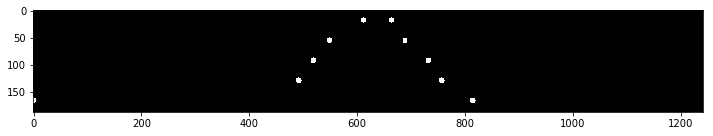

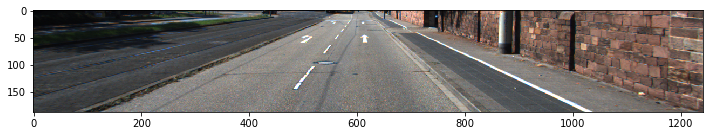

In [14]:
points = np.zeros(masked_edges.shape)
for i in range(len(hists)):
    left = np.argmax(left_hists[i])
    right = np.argmax(right_hists[i]) + midpoint
    
    left_center = (left, (divide * i) + int(divide/2))
    right_center = (right, (divide * i) + int(divide/2))
    
    cv2.circle(points, left_center, 5, (255,255,255), -1)
    cv2.circle(points, right_center, 5, (255,255,255), -1)
    
plt.figure(figsize=(12,12))
plt.imshow(points, cmap="gray")
plt.show()

plt.figure(figsize=(12,12))
plt.imshow(img)
plt.show()

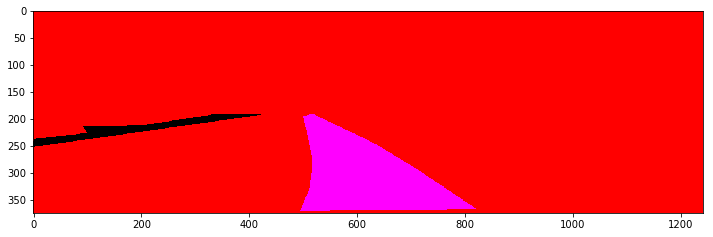

(375, 1242, 3)
[ 1.  0.  0.]
[ 1.  0.  1.]


In [15]:
gt_img = mpimg.imread(cwd+'/Data/data_road/training/gt_image_2/um_lane_000000.png')
plt.figure(figsize=(12,12))
plt.imshow(gt_img)
plt.show()
print(gt_img.shape)
print(gt_img[0,0,:])
print(gt_img[325,600,:])

[  3.59275352e-04  -1.92427843e-01   2.85812166e+02]


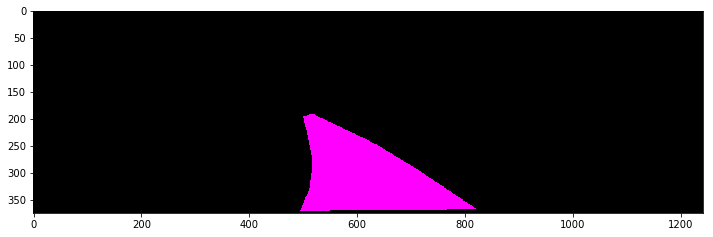

In [16]:
h = gt_img.shape[0]
w = gt_img.shape[1]
x_pixels = []
y_pixels = []
for i in range(h):
    for j in range(w):
        p0 = gt_img[i,j,0]
        p1 = gt_img[i,j,1]
        p2 = gt_img[i,j,2]
        if p0 != 1. or p1 != 0. or p2 != 1.:
            gt_img[i,j,0] = 0
            gt_img[i,j,1] = 0.
            gt_img[i,j,2] = 0.
        else:
            x_pixels.append(j)
            y_pixels.append(i)
fit = np.polyfit(x_pixels, y_pixels, 2)
print(fit)

plt.figure(figsize=(12,12))
plt.imshow(gt_img)
plt.show()

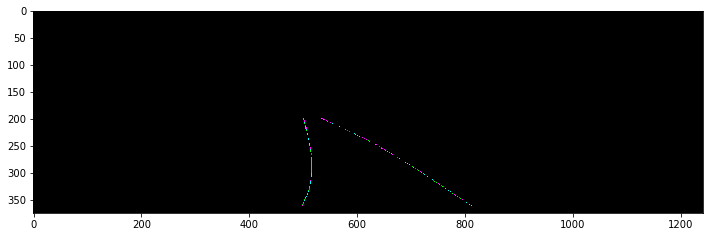

'    \nplt.figure(figsize=(12,12))\nplt.imshow(gt_img)\nplt.show()\n'

In [18]:
recreated = np.zeros_like(gt_img)

combined_y = {}
for y,x in zip(y_pixels, x_pixels):
    if y not in combined_y:
        combined_y[y] = [x]
    else:
        combined_y[y].append(x)

left_pixels = []
right_pixels = []
for y in combined_y:
    left_most = w
    right_most = 0
    for x in combined_y[y]:
        if x < left_most:
            left_most = x
        if x > right_most:
            right_most = x
    left_pixels.append([y, left_most])
    right_pixels.append([y, right_most])


lsize = len(left_pixels)
rsize = len(right_pixels)
l1 = int(.05 * lsize)
l2 = int(.95 * lsize)
r1 = int(.05 * rsize)
r2 = int(.95 * rsize)
left_pixels = left_pixels[l1:l2]
right_pixels = right_pixels[r1:r2]
    
    
for left,right in zip(left_pixels, right_pixels):
    recreated[left[0], left[1],0] = 1
    recreated[left[0], left[1],1] = 0
    recreated[left[0], left[1],2] = 1
    
    recreated[right[0], right[1],0] = 1
    recreated[right[0], right[1],1] = 0
    recreated[right[0], right[1],2] = 1

    
left_pixels = np.array(left_pixels)
right_pixels = np.array(right_pixels)

left_y = left_pixels[:,0]
left_x = left_pixels[:,1]

right_y = right_pixels[:,0]
right_x = right_pixels[:,1]

left_fit = np.polyfit(left_y, left_x, 3)
right_fit = np.polyfit(right_y, right_x, 3)

for ly, ry in zip(left_y, right_y):
    lx = int(left_fit[0]*ly**3 + left_fit[1]*ly**2 + left_fit[2]*ly + left_fit[3])
    rx = int(right_fit[0]*ry**3 + right_fit[1]*ry**2 + right_fit[2]*ry + right_fit[3])
    
    if lx < w:
        recreated[ly,lx,0] = 0
        recreated[ly,lx,1] = 1

    if lx < w:
        recreated[ry,rx,0] = 0
        recreated[ry,rx,1] = 1


plt.figure(figsize=(12,12))
plt.imshow(recreated)
plt.show()
"""    
plt.figure(figsize=(12,12))
plt.imshow(gt_img)
plt.show()
"""

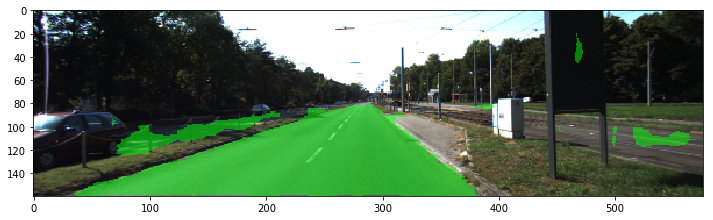

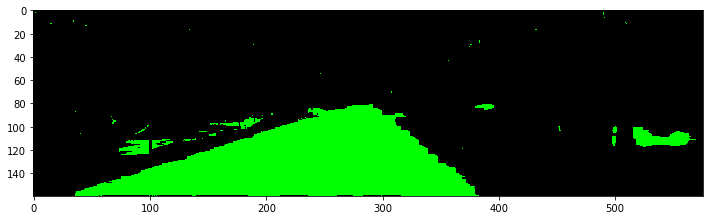

In [52]:
seg_img = mpimg.imread('/home/mikep/Documents/Udacity/Autonomous/Udacity-Autonomous-Car-Term3/Semantic_Segmentation/runs/1509655397.33/um_000000.png')
plt.figure(figsize=(12,12))
plt.imshow(seg_img)
plt.show()

seg_ind = np.zeros_like(seg_img)
h = seg_img.shape[0]
w = seg_img.shape[1]
for i in range(h):
    for j in range(w):
        r = seg_img[i,j,0]
        g = seg_img[i,j,1]
        b = seg_img[i,j,2]
        if r < .5 and g > .6 and b < .5:
            seg_ind[i,j,1] = 1
plt.figure(figsize=(12,12))
plt.imshow(seg_ind)
plt.show()
plt.imsave('seg.png', seg_ind)

ind_img = []
for i in range(h):
    for j in range(w):
        if seg_ind[i,j,1] == 1:
            ind_img.append([i,j])

from sklearn.cluster import DBSCAN
db = DBSCAN(eps=1, min_samples=100).fit(ind_img)

(160, 576, 3)


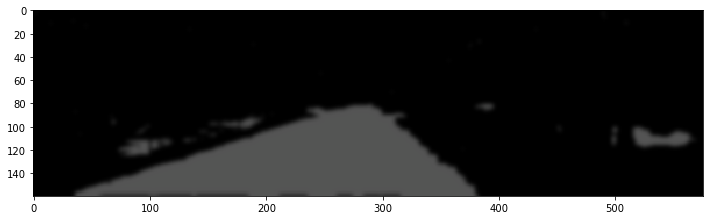

In [67]:
from scipy.ndimage.filters import gaussian_filter

out = gaussian_filter(seg_ind,2)

print(out.shape)

plt.figure(figsize=(12,12))
plt.imshow(out, cmap='gray')
plt.show()

In [53]:
from sklearn import metrics

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

for l in labels:
    print(l)

Estimated number of clusters: 0
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-